<a href="https://colab.research.google.com/github/mjiii25/prac_class/blob/main/team-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 데이터 로드 및 건물별 전력사용량 파악

In [26]:
library(data.table)
library(magrittr)
library(ggplot2)
library(plotly)
library(factoextra)

In [27]:
dt_train = fread('/content/train.csv')
names(dt_train) = c('num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', 
                    '비전기냉방설비운영', '태양광보유')

In [28]:
dt_train[, date_time := as.POSIXct(date_time, tz = '', format = '%F %H')]
dt_train[, `:=`(date = as.Date(date_time, tz=''),
                 hour = as.factor(format(date_time, format='%H')),
                 dow  = as.factor(format(date_time, format='%u')))]

날짜시간 변수 형식을 활용해서 새로운 변수 date(날짜), hour(시간), dow(요일) 추출

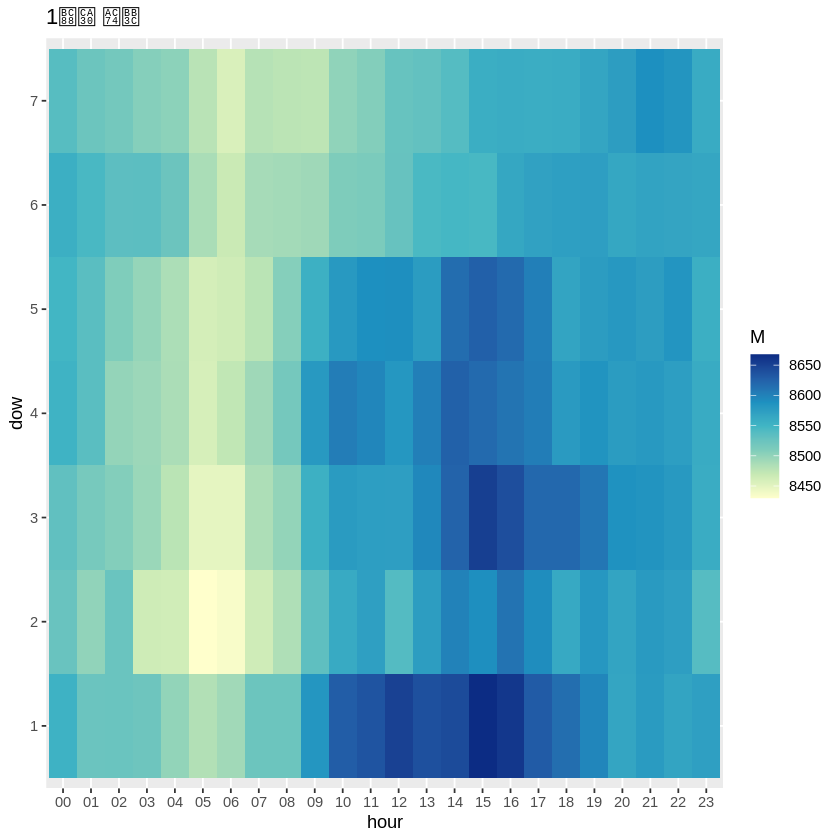

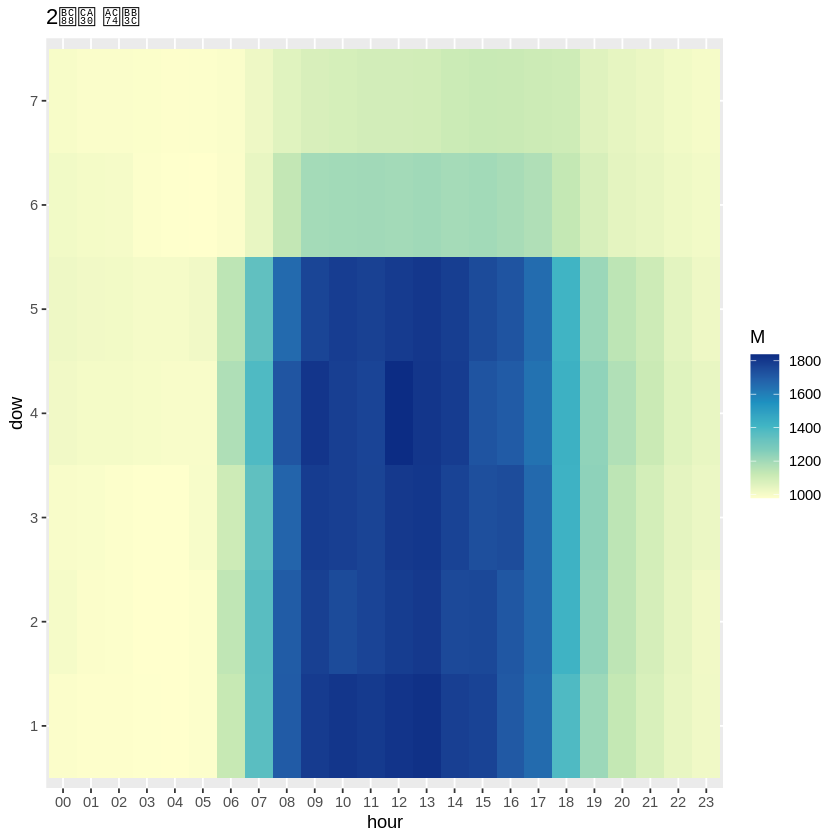

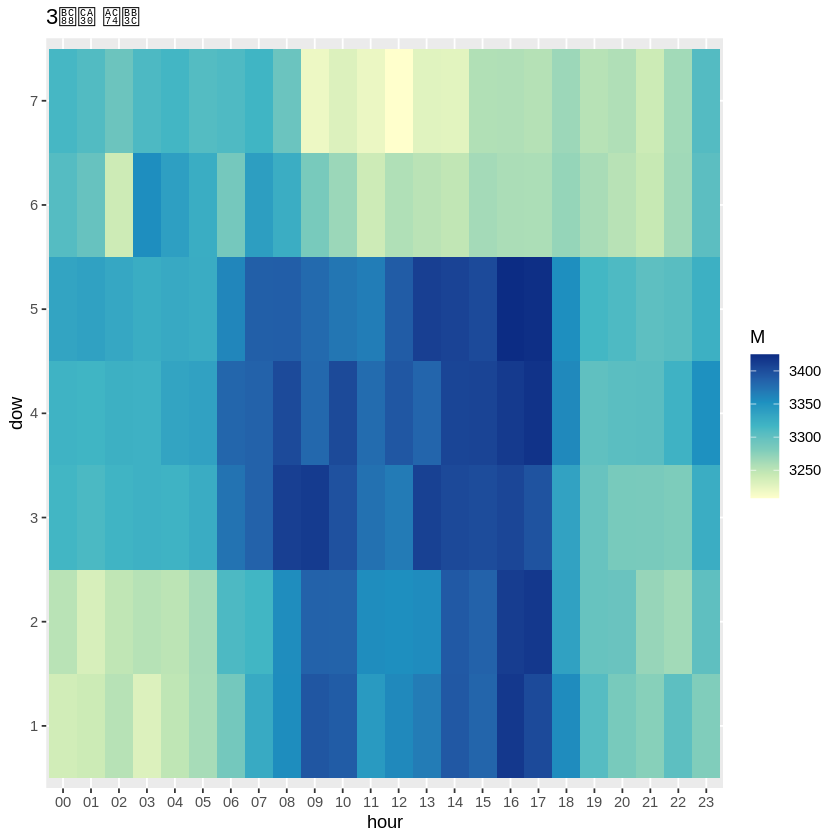

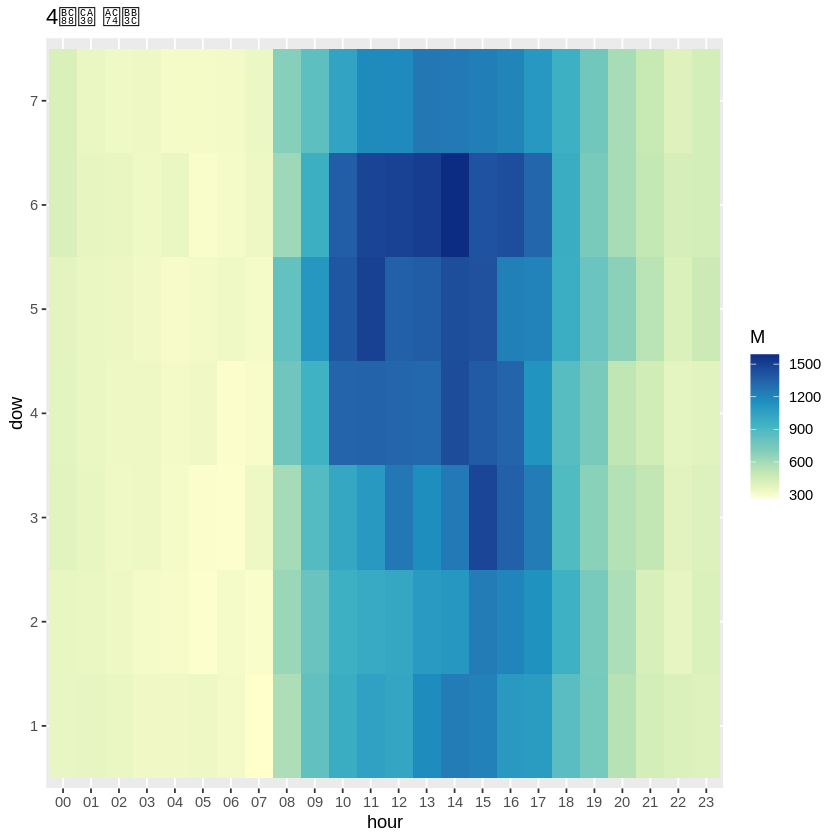

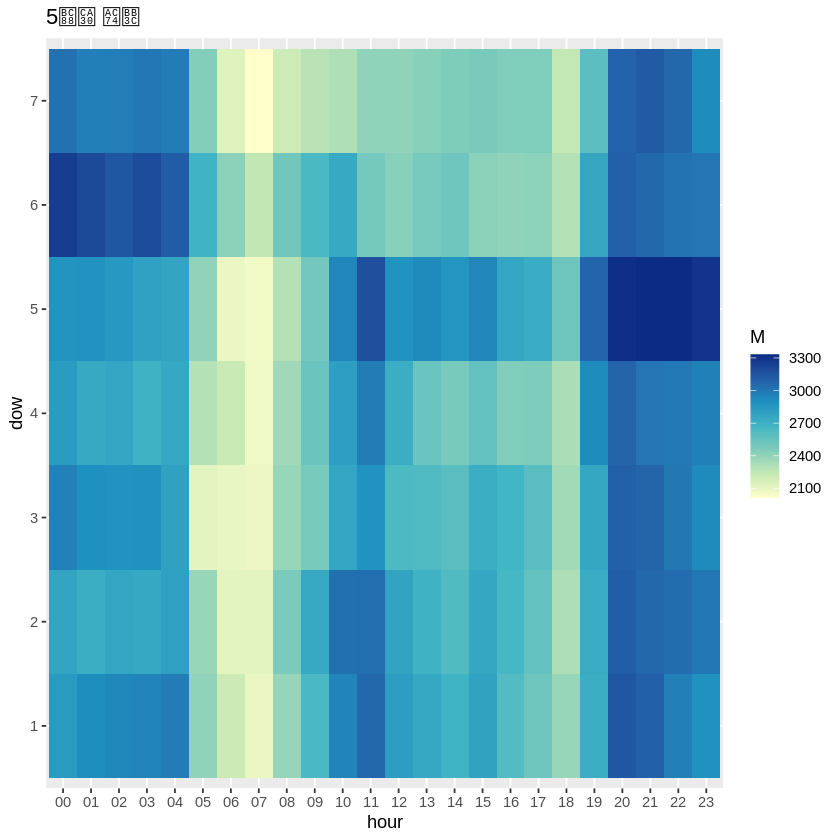

In [29]:
for(i in 1:5){
  p = dt_train[num == i, .(M = median(전력사용량)), by = .(hour, dow)] %>%
  ggplot(aes(hour, dow, fill = M)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1) +
  ggtitle(paste0(i, '번쨰 건물'))
  plot(p)
}

** 시간 및 요일별 전력사용량의 중앙값 계산 (건물마다 존재하는 이상치 보완)

1번째 건물
- 요일 및 시간 상관없이 8400 - 8900 수준
- 항상 돌아가는 공장

2번째 건물
- 월 - 금, 9 to 6, 나머지 시간대에는 전력사용량이 절반 수준
- 사무실

3번째 건물
- 2번과 비슷 BUT 3200 - 3450 수준
- 2번보다는 평일 작업이 많은 공장

4번째 건물
- 밤 - 새벽에는 사람 없음, 목금토 낮에 많이 붐빔
- 낮에만 여는 공원

5번째 건물
- 평일 점심시간, 저녁 8시 이후, 특히 불금 - 토새벽에 사람 몰림
- 먹고 마시는 곳

#### 건물 군집화

24시간을 3시간씩 나눠 건물 /요일/시간대(3시간)별전력사용량의 중앙값 계산

In [30]:
# 특정 건물의 요일/3시간별 전력사용량
dt_train[, hour_by3 := formatC((as.integer(format(date_time, format = '%H')) %/% 3) * 3, width = 2, flag = '0')]
agg_cl = dt_train[, .(M = median(전력사용량)), by = .(num, hour_by3, dow)]
agg_cl[, R := M/max(M), by = .(num)]
dt_cl = dcast(agg_cl, num ~ dow + hour_by3, value.var = 'R')

In [31]:
# 계층적 군집화
dist_building = dist(dt_cl[,-1])
hc_building = hclust(dist(dt_cl[-1]), method = 'ward.D2')

Warning message in if (color == "cluster") color <- "default":
“the condition has length > 1 and only the first element will be used”


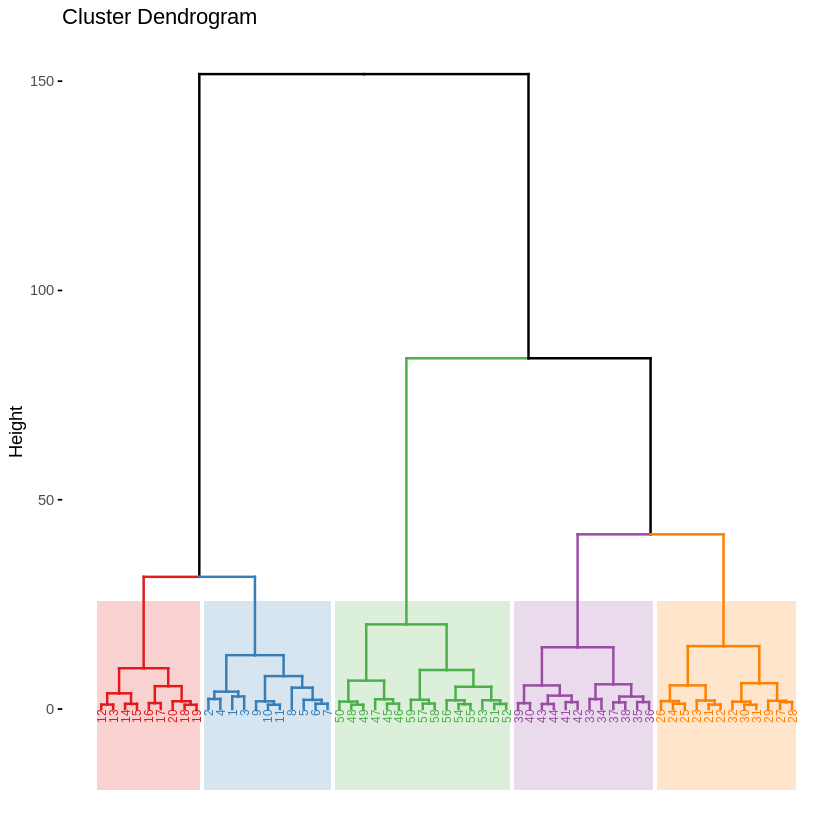

In [32]:
# 군집화 시각화
fviz_dend(hc_building, k = 5,
          cex = 0.5,
          k_colors = RColorBrewer::brewer.pal(5, 'Set1'),
          color_labels_by_k = TRUE,
          rect = TRUE,
          rect_border = RColorBrewer::brewer.pal(5, 'Set1'),
          rect_fill = TRUE)

#### 군집별 요일/시간대에 따른 전력사용량

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 59 rows but longest item has 60; recycled with remainder.”


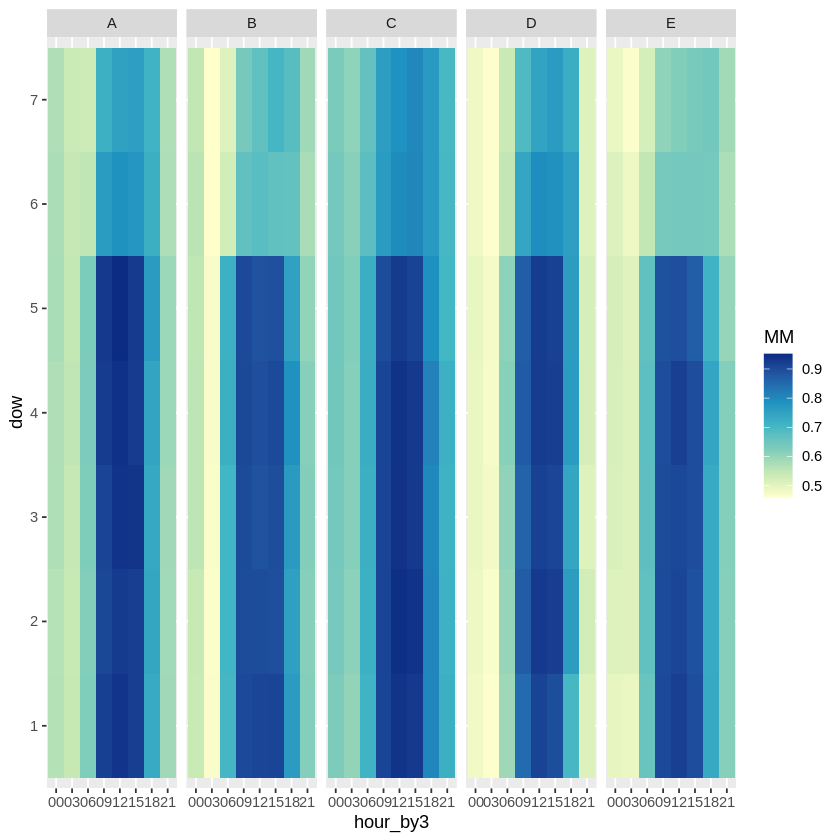

In [33]:
dt_cl_result = data.table(num = 1:60, grp = LETTERS[cutree(hc_building, k = 5)])
agg_cl[dt_cl_result, on = .(num), G := i.grp]

agg_cl[, .(MM = mean(R)), by = .(G, hour_by3, dow)] %>%
  ggplot(aes(hour_by3, dow, fill = MM)) +
  geom_tile() +
  scale_fill_distiller(palette = 'YlGnBu', direction = 1) +
  facet_grid(cols = vars(G))

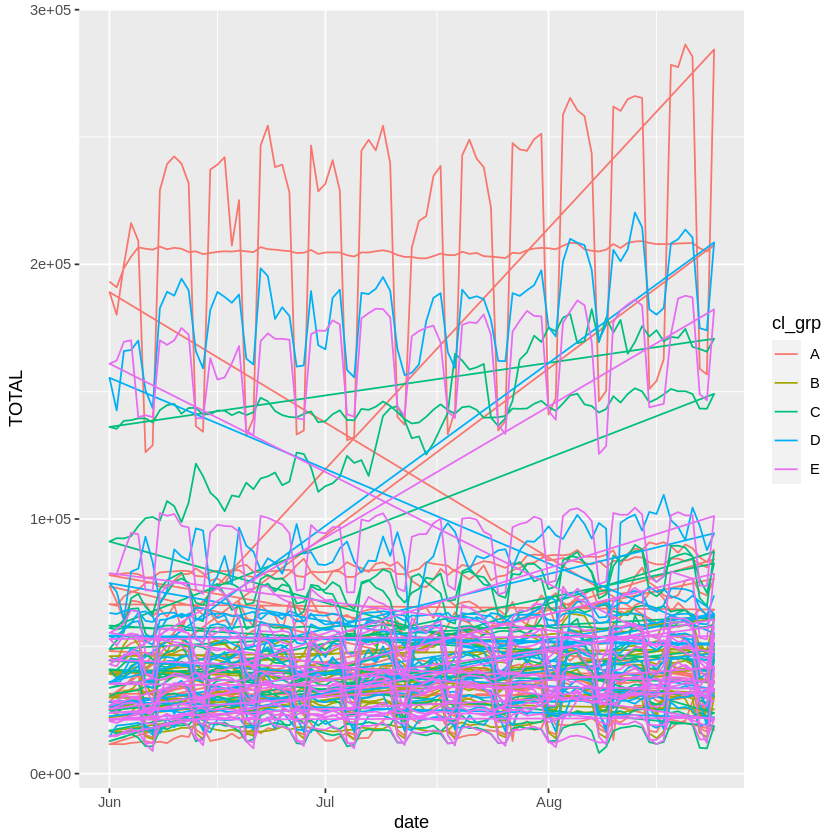

In [35]:
# 일별 전력사용량
dt_train[dt_cl_result, on = .(num), cl_grp := i.grp]
p_cl = dt_train[, .(TOTAL = sum(전력사용량)), by = .(num, cl_grp, date)] %>%
  ggplot(aes(date, TOTAL, group - num, color = cl_grp)) +
  geom_path()

p_cl